# Overview of the notebook

We will find the engagement of the users in the forum for the subject mlp

## Take an example of mlp course:

1. Find all the topics from the mlp category's JSON. We can filter them by date to find all the topics that were created in that particular term. STORE ALL TOPIC_IDs in a LIST (say t_list).
2. For each topic_id, there is a user who created it and a bunch of users who replied to that topic. We will STORE EACH USER_ID in a LIST (say u_list).
3. So now we have a list of users who were involved in atleast one topic for the subject mlp.
4. Now we will LOOP THROUGH EACH USER FROM U_LIST, call the API which returns all its user_actions (filtered by date).
5. Loop through all user actions, each user_action is associated with a topic_id. We will analyse only those user_actions whose topic_id is in t_list.

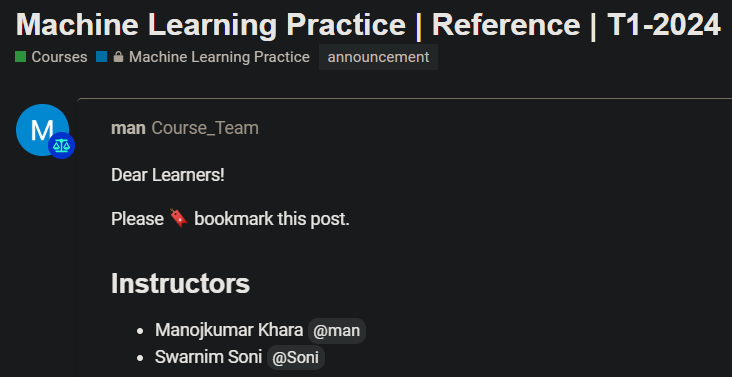

# Global variables and general imports

In [2]:
import os, json, requests, time
from pprint import pprint
from datetime import datetime
import pandas as pd

import yaml
with open("../key.yaml", "r") as file:
    api_keys = yaml.safe_load(file)

api_key = api_keys["API_KEY"]
api_username = "ShubhamG"
defaultHost = "discourse.onlinedegree.iitm.ac.in"

# Headers for authentication
headers = {
    'Api-Key': api_key,
    'Api-Username': api_username
}

after, before = "2024-01-22", "2024-04-28" # Date range for which we want to get the data

# Step 1: Get all the topic_ids of mlp course from the API

In [2]:
slug, id = "mlp-kb", 33
page = 0
topic_ids = set() # a set of strings

while True:
    page+=1 # Each page will have 50 topics
    time.sleep(0.8)
    endpoint = f"https://{defaultHost}/search.json?q=%23courses%3A{slug}%20after%3A{after}%20before%3A{before}&page={page}"
    
    response = requests.get(endpoint, headers=headers) # Make the request

    if response.status_code == 200: # Check the response
        data = response.json()
        topic_list = data["topics"]
        topic_ids = set(str(topic["id"]) for topic in topic_list).union(topic_ids)
        if not data['grouped_search_result']['more_full_page_results']: # If there are no more topics, break the loop
            print(f"Number of topics on last page = {page} is {len(topic_list)}")
            break
        
    else:
        print(f'Error: {response.status_code}')
        break
print(f"Total number of topics = {len(topic_ids)}")

Number of topics on last page = 9 is 32
Total number of topics = 432


In [3]:
len(topic_ids), list(topic_ids)[:5]

(432, ['127457', '115639', '124772', '124088', '125853'])

In [4]:
# # Store topic_ids in a text file
# with open('topic_ids_mlp.txt', 'w') as f:
#     for topic_id in topic_ids:
#         f.write(f"{topic_id}\n")

# # # Retrieve topic_ids from the text file
# # with open('topic_ids_mlp.txt', 'r') as f:
# #     topic_ids = [line.strip() for line in f]

# Step:2 Store each user_id in a list who were involved in above topics

In [5]:
usernames = set() # set of usernames of data type int
for topic_id in topic_ids:
    time.sleep(0.8)
    endpoint = f"https://{defaultHost}/t/{topic_id}.json"
    response = requests.get(url=endpoint, headers=headers)
    if response.status_code==200:
        data = response.json()
        for post in data['post_stream']['posts']: #Each topic has a list of posts, each post has a username
            usernames.add(post['username'])
    else:
        print(f"Error: {response.status_code}\n{response.text}")
        break

In [6]:
len(usernames), list(usernames)[:5]

(235,
 ['chaitanya353535', 'diwakar999', '21f1005146', 'ParagSeth', 'muharnmad'])

In [7]:
# Store usernames in a text file
# with open('usernames_mlp.txt', 'w') as f:
#     for username in usernames:
#         f.write(f"{username}\n")

# # Retrieve topic_ids from the text file
# with open('usernames.txt', 'r') as f:
#     usernames = [line.strip() for line in f]

# STEP 3: GET THE USER_ACTION of each user from usernames_list

In [8]:
# Keep the below code in a loop and increment the offset by 30 each time. The loop should break when the number of elements in the response is less than 30
data_dict ={} # Dictionary to store userActions by username
before_date = datetime.strptime(before, "%Y-%m-%d")
for index, username in enumerate(list(usernames)):
    data_dict[username] = []
    offset = 0
    while True:
        time.sleep(0.8)
        endpoint = f'https://{defaultHost}/user_actions.json?username={username}&offset={offset}&after={after}'
        response = requests.get(endpoint, headers=headers)

        if response.status_code == 200:
            data = response.json()
            user_actions = data["user_actions"]
            num_elements = len(user_actions)

            filtered_user_actions = []
            for action in user_actions:
                topic_id = str(action["topic_id"])
                if (topic_id in topic_ids):
                    created_at = datetime.strptime((action["created_at"]).split("T")[0], "%Y-%m-%d")
                    if created_at <= before_date:
                        filtered_user_actions.append(action)
                        # print(f"topic_id: {topic_id}, created_at: {created_at}")
            data_dict[username].extend(filtered_user_actions)
            offset+=30
            if num_elements<30:
                break
        else:
            print(f'Error: {response.status_code}')
            break
    print(f"[For MLP T1-2024] Length [user_actions] : [{index}] username= {username} : {len(data_dict[username])}")

[For MLP T1-2024] Length [user_actions] : [0] username= chaitanya353535 : 54
[For MLP T1-2024] Length [user_actions] : [1] username= diwakar999 : 3
[For MLP T1-2024] Length [user_actions] : [2] username= 21f1005146 : 66
[For MLP T1-2024] Length [user_actions] : [3] username= ParagSeth : 5
[For MLP T1-2024] Length [user_actions] : [4] username= muharnmad : 5
[For MLP T1-2024] Length [user_actions] : [5] username= KAPS_ON_AIR : 2
[For MLP T1-2024] Length [user_actions] : [6] username= 22f3001578 : 2
[For MLP T1-2024] Length [user_actions] : [7] username= 22f1000068 : 7
[For MLP T1-2024] Length [user_actions] : [8] username= AaM_Admi : 2
[For MLP T1-2024] Length [user_actions] : [9] username= 22f1000522 : 32
[For MLP T1-2024] Length [user_actions] : [10] username= suhas26 : 10
[For MLP T1-2024] Length [user_actions] : [11] username= rajinips : 9
[For MLP T1-2024] Length [user_actions] : [12] username= himanshutiwari16 : 42
[For MLP T1-2024] Length [user_actions] : [13] username= Adhya : 9

In [9]:
# dump data_dict as json file
import json
with open('data_dict_mlp_T12024.json', 'w') as fp:
    json.dump(data_dict, fp, indent=4)

In [10]:
len(data_dict)

235

# STEP 4: Create a dataframe with the data of all users

In [12]:
action_to_description = {
"1": "likes_given",
"2": "likes_recieved",
"3": "user_bookmarked_a_post",
"4": "created_a_new_topic",
"5": "replied",
"6": "recieved_a_response",
"7": "user_was_mentioned",
"9": "user's_post_was_quoted",
"11": "user_edited_the_post",
"12": "user_sent_a_new_private_message",
"13": "recieved_a_private_message",
"15": "user_marked_a_post_as_solution",
"16": "user_was_assigned_a_topic_or_post",
"17": "linked"
}

def map_user_actions(data_list):
    number_of_actions = {v: 0 for v in action_to_description.values()}
    number_of_actions["Solutions_posted"] = 0
    # Each element of data_list has a key called "action_type". We have to populate the dictionary number_of_actions with the count of each action_type.
    for element in data_list[:]:
        action_int = element["action_type"] # For example, "1"
        action_type = action_to_description[str(action_int)] # If action_int=1, then action_types=likes_given
        number_of_actions[action_type] += 1 # number_of_actions[likes_given] = number_of_actions.get(likes_given, 0) + 1
        if action_int == 5: # This will be used to find the number of solutions posted by the user
            time.sleep(0.8)
            post_id = element["post_id"]
            endpoint = f"https://{defaultHost}/posts/{post_id}.json"

            response = requests.get(endpoint, headers=headers)         
            if response.status_code==200:
                data=response.json()
                if data["accepted_answer"] == True: # the post was accepted as a solution
                    number_of_actions["Solutions_posted"] += 1
            else:
                print(f"Error: {response.status_code}")
                print(response.text)
    return number_of_actions

In [13]:
mlp_dataframe = pd.DataFrame(columns=["username"]+[v for k, v in action_to_description.items()]) # dataframe with username and action columns from the action_to_description dictionary
users = list(data_dict.keys())
for index, user in enumerate(users[:]):
    if index%25 == 0: print(index, user)
    # print(data_dict[user])
    D = map_user_actions(data_dict[user])
    D["username"] = user
    mlp_dataframe = pd.concat([mlp_dataframe, pd.DataFrame(D, index=[0])], ignore_index=True)

mlp_dataframe.sample(5)

0 chaitanya353535
25 21f2000885
50 22f3001632
75 21f3000292
100 21f1001712
125 Abhinandan
150 Soni
175 23f1001441
200 CHapPY
225 ANEKANT_MANTHAN


,username,likes_given,likes_recieved,user_bookmarked_a_post,created_a_new_topic,replied,recieved_a_response,user_was_mentioned,user's_post_was_quoted,user_edited_the_post,user_sent_a_new_private_message,recieved_a_private_message,user_marked_a_post_as_solution,user_was_assigned_a_topic_or_post,linked,Solutions_posted
40,RITAM17,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0
139,23f1001749,0,14,0,11,18,58,1,0,0,0,0,0,0,0,0.0
109,aasthaawasthi,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.0
171,TanishaA,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0.0
84,21f3001993,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1.0


In [3]:
# mlp_dataframe.to_csv('mlp_engagement.csv', index=False)
mlp_dataframe = pd.read_csv('mlp_engagement.csv')

In [4]:
mlp_dataframe.drop(columns=["user_bookmarked_a_post","recieved_a_response", "user_was_mentioned","user_edited_the_post","user_sent_a_new_private_message","recieved_a_private_message","user_was_assigned_a_topic_or_post","linked"], inplace=True) # drop the irrelevant columns
mlp_dataframe.sample(5)

,username,likes_given,likes_recieved,created_a_new_topic,replied,user's_post_was_quoted,user_marked_a_post_as_solution,Solutions_posted
199,keertityagi,0,0,0,1,0,0,0.0
200,CHapPY,1,4,1,0,0,0,0.0
38,22f1001809,0,1,2,1,0,0,0.0
224,22ds3000009,0,0,0,1,0,0,0.0
209,blprohit,3,0,0,1,0,0,0.0


In [5]:
# Assign the weights to the relevant columns. This can be changed as per the requirement.
weights_dict = { 'likes_given': 0.3, # 0.3
                "likes_recieved": 0.8, # changed from 0.7
                "created_a_new_topic": 0.5, # changed from 1.0
                "replied": 0.7,
                "user's_post_was_quoted": 0.6,
                "user_marked_a_post_as_solution":0.2,
                "Solutions_posted": 1
}
columns_to_be_ignored = ["initial_score",'subject','username','overall_topics_count_of_this_subject', 'normalised_score', 'z_score'] # this was directly taken from previous notebook. Some column names might seem irrelevant. Please ignore them.

mlp_dataframe["initial_score"] = sum(mlp_dataframe[column]*weights_dict[column] for column in mlp_dataframe.columns if column not in columns_to_be_ignored) # Initial score = sum(column_value*weight)

# merged_df["normalised_score"] = merged_df["initial_score"] / merged_df ["overall_topics_count_of_this_subject"] # normalised_score # THIS PART IS OMITTED AS WE ARE CALCULATING THE SCORES ONLY FOR mlp USERS AND NOT COMPARING THEM WITH OTHER SUBJECTS

mlp_dataframe["z_score"] = round((mlp_dataframe["initial_score"] - mlp_dataframe["initial_score"].mean()) / mlp_dataframe["initial_score"].std(),2) # z_score

final_scores = mlp_dataframe[["username", "initial_score", "z_score"]]

In [6]:
mlp_dataframe.to_excel('mlp_final_scores.xlsx', index=False)

In [7]:
final_scores[final_scores["z_score"] > 1.5]

,username,initial_score,z_score
33,sayan,32.8,1.59
45,23ds1000113,37.8,1.91
66,aaruni-kale,44.2,2.32
76,Devarayi,34.2,1.68
81,22f3001311,32.3,1.56
91,man,43.9,2.30
112,iitmanupam,146.4,8.83
121,Paramitaghosh,32.8,1.59
144,22f2001236,32.2,1.55
150,Soni,82.9,4.78


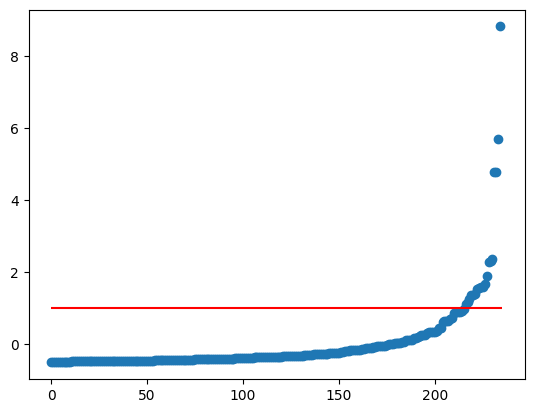

In [8]:
# Plot a scatter plot of the z-scores
import matplotlib.pyplot as plt
z_scores = mlp_dataframe["z_score"].sort_values(ascending=True)
plt.scatter(range(0,len(z_scores)),z_scores)
plt.hlines(y=1,xmin=0,xmax=len(z_scores),color='red')
plt.show()